#### Goal: Simulate a vrms map with Jampy axi rms.

For this, we are using a MGE light decomposition of SDP.81 (already in proper units, and stored in JAM_Input.txt).

Beside that, we include a eNFW profile for dark matter (stored in eNFW.txt with kappa_s equal to one, but we change it during the simulation).

We are using a MUSE psf.
Attention to sigmapsf, it is in pixel, not in arcsec.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plotbin.plot_velfield import plot_velfield
from My_Jampy import JAM                          #My class for jampy

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_4/Simulation_Data/"

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)      #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)           #DM component
norm_psf, sigma_psf           = np.loadtxt("Input/MUSE_Psf_model.txt", unpack=True) #PSF

In [3]:
z_l     = 0.299                                                         #Redshift
D_l     = cosmo.angular_diameter_distance(z_l).value                    #Distance to Lens [Mpc] 
mbh     = 1e9                                                           #mass of black hole [log10(M_sun)]
beta    = np.full_like(surf_lum, -0.15)                                  #anisotropy [ad]
inc     = 65                                                            #inclination [deg]
inc_rad = np.radians(inc)
qinc    = np.sqrt(np.min(qobs_lum)**2 - 
                    (1 - np.min(qobs_lum)**2)/np.tan(inc_rad)**2)       #Deprojected axial ratio for inclination
qDM     = np.sqrt( qobs_dm[0]**2 - np.cos(inc_rad)**2)/np.sin(inc_rad)  #Deprojected DM axial ratio
kappa_s = 0.075                                                         #kappa_s of DM profile
ml      = 7.00                                                          #mass to light ratio

pixsize = 0.2    #MUSE pixel size
print("qInc: %.4f" %qinc)
print("qDM: %.4f"  %qDM)

qInc: 0.3884
qDM: 0.8137


In [4]:
#Grid with xbin and ybin position (in px)
np.random.seed(123)
xbin, ybin = np.random.uniform(low=[-30, -20], high=[30, 20], size=[100, 2]).T

In [5]:
#Now we start our Jampy class
Jam_model = JAM(ybin=ybin*pixsize, xbin=xbin*pixsize, inc=inc, distance=D_l, mbh=mbh, beta=beta,
                   normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

#Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml)
#Add DM component
Jam_model.DM_component(surf_dm=kappa_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

jam_axi_rms elapsed time sec: 0.88


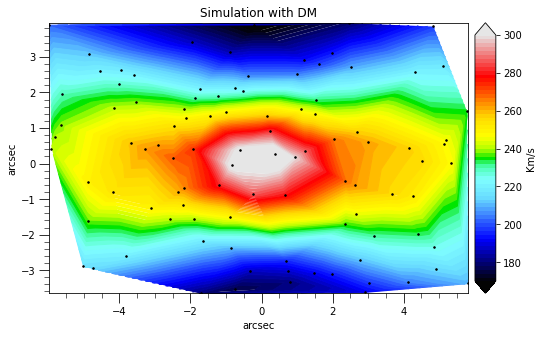

In [6]:
#Run my Jam class
My_model, ml = Jam_model.run_simulation(plot=True, quiet=False, cmap="sauron", nodots=False)
plt.figure(figsize=(8,6))
plot_velfield(x=xbin*pixsize, y=ybin*pixsize, vel=My_model, vmin=170, vmax=300,colorbar=True, label="Km/s")
plt.title("Simulation with DM")
plt.xlabel("arcsec")
plt.ylabel("arcsec")



plt.savefig(data_folder+"Vrms_Map_without noise.png", fmt="png")

In [7]:
#Add some gaussian noise in Vrms map
noisy_vrms = np.random.normal(My_model,0.05*np.median(My_model))

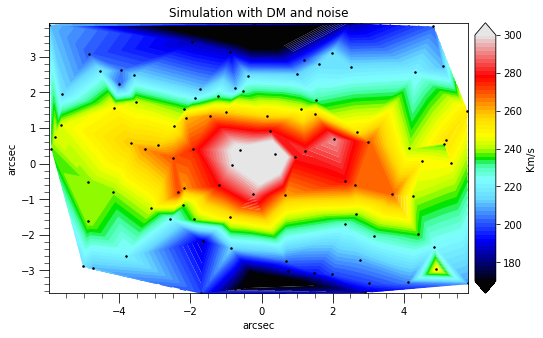

In [8]:
plt.figure(figsize=(8,6))
plot_velfield(x=xbin*pixsize, y=ybin*pixsize,vel=noisy_vrms, vmin=170, vmax=300, colorbar=True, label="Km/s",)
plt.title("Simulation with DM and noise")
plt.xlabel("arcsec")
plt.ylabel("arcsec")



plt.savefig(data_folder+"Vrms_Map_noisy.png", fmt="png")

In [9]:
print("STD of residual:", np.std(My_model - noisy_vrms))
print("Sigma used for compute noise:", 0.05*np.median(My_model))

STD of residual: 11.08343040529613
Sigma used for compute noise: 11.818539651333817


Text(0, 0.5, 'Vrms [km/s]')

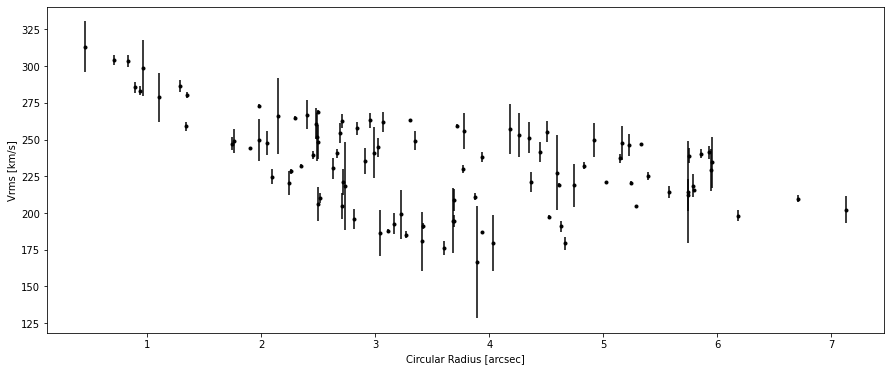

In [10]:
plt.figure(figsize=(15,6))
plt.errorbar(x = pixsize*np.sqrt(xbin**2 + ybin**2), y=My_model,  yerr=abs(My_model - noisy_vrms), fmt=".k")
plt.xlabel("Circular Radius [arcsec]")    
plt.ylabel("Vrms [km/s]")

Text(0, 0.5, 'arcsec')

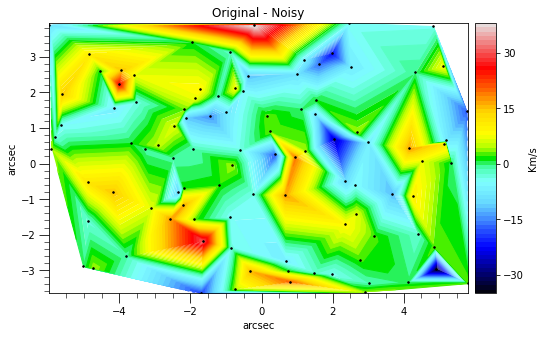

In [11]:
plt.figure(figsize=(8,6))
plot_velfield(x=xbin*pixsize, y=ybin*pixsize,vel=My_model-noisy_vrms, colorbar=True, label="Km/s")
plt.title("Original - Noisy")
plt.xlabel("arcsec")
plt.ylabel("arcsec")

In [12]:
np.savetxt(data_folder+"vrms_data.txt", np.column_stack([xbin, ybin, noisy_vrms, abs(My_model - noisy_vrms)]),
                          fmt=b'%.8e \t %.8e \t %.8e \t %.8e', 
                            header="xbin [px] \t ybin [px] \t vrms [Km/s] \t erms [km/s]")

### Recovery test

In [13]:
x, y, vrms, erms              = np.loadtxt(data_folder+"vrms_data.txt", unpack=True)  #vrms data
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)              #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)                   #DM component
norm_psf, sigma_psf           = np.loadtxt("Input/MUSE_Psf_model.txt", unpack=True)         #PSF

In [14]:
z_l     = 0.299                                                         #Redshift
D_l     = cosmo.angular_diameter_distance(z_l).value                    #Distance to Lens [Mpc] 
mbh     = 1e9                                                           #mass of black hole [log10(M_sun)]
beta    = np.full_like(surf_lum, -0.15)                                  #anisotropy [ad]
inc     = 65                                                            #inclination [deg]
kappa_s = 0.075                                                         #kappa_s of DM profile
ml      = 7.00                                                          #mass to light ratio

pixsize = 0.2    #MUSE pixel size

In [15]:
#Now we start our Jampy class
Jam_model = JAM(ybin=y*pixsize, xbin=x*pixsize, inc=inc, distance=D_l, mbh=mbh, beta=beta, rms=vrms, erms=erms,
                   normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

#Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml)
#Add DM component
Jam_model.DM_component(surf_dm=kappa_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

jam_axi_rms elapsed time sec: 0.65
inc=65.0 beta_z=-0.15 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 3.854e+13


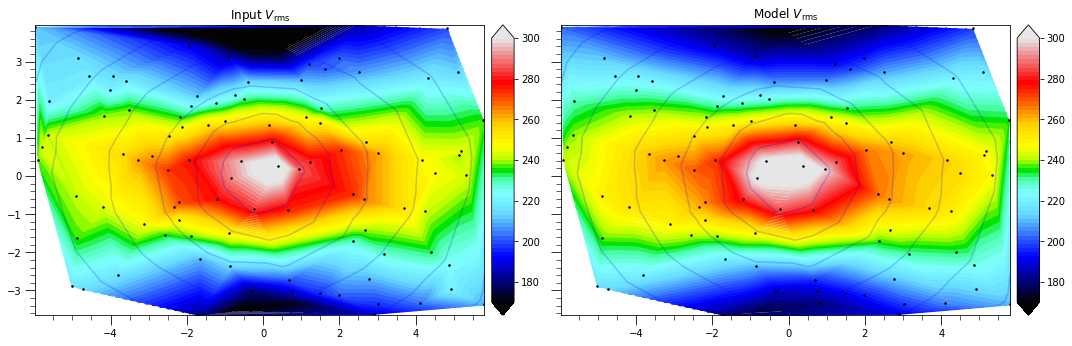

In [16]:
#Run my Jam class
plt.figure(figsize=(15,15))
My_model, ml, chi2, chi2T = Jam_model.run(plot=True, vmin=170, vmax=300, quiet=False, cmap="sauron",nodots=False)
plt.tight_layout()